### 4. Análise Financeira

**a. Análise de Lucratividade por Categoria:**  
Calcular a lucratividade de diferentes categorias de produtos, levando em conta o custo dos produtos e o preço de venda.


### Configuração do Ambiente e Carga de Dados

A primeira etapa consiste na preparação do ambiente de análise. O código a seguir importa as bibliotecas necessárias — **PySpark** para manipulação de dados e **Matplotlib/Seaborn** para visualização — e carrega os datasets do Unity Catalog para DataFrames Spark.

In [0]:
# Importa funções essenciais do PySpark
from pyspark.sql.functions import col, to_timestamp, datediff, avg, when, round, sum as _sum, countDistinct, year, month, quarter, count
from pyspark.sql import functions as F
from pyspark.sql.window import Window


# Importa as bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors


# Carrega cada tabela diretamente do seu catálogo e schema
customers_df = spark.table("workspace.default.olist_customers")
orders_df = spark.table("workspace.default.olist_orders")
order_items_df = spark.table("workspace.default.olist_order_items")
payments_df = spark.table("workspace.default.olist_order_payments")
reviews_df = spark.table("workspace.default.olist_order_reviews")
products_df = spark.table("workspace.default.olist_products")
sellers_df = spark.table("workspace.default.olist_sellers")
geolocation_df = spark.table("workspace.default.olist_geolocation")

print("Todos os datasets foram carregados com sucesso a partir do Unity Catalog.")

Todos os datasets foram carregados com sucesso a partir do Unity Catalog.


### Etapa 2: Preparação dos Dados para Análise Financeira

Esta etapa de ETL (Extração, Transformação e Carga) prepara os dados brutos para a análise. O objetivo é criar um DataFrame unificado que contenha as informações financeiras essenciais para cada item vendido, associadas à sua respectiva categoria de produto.

O processo consiste em:

- **Consolidação (Join):** Une a tabela de itens de pedido (`order_items_df`) com a tabela de produtos (`products_df`) para conectar o preço e o valor do frete com a categoria do produto.

- **Seleção e Limpeza:** Seleciona apenas as colunas necessárias para a análise e remove quaisquer registros que não possuam uma categoria de produto definida, garantindo a qualidade dos dados.


In [0]:
# Etapa 2: Preparação dos Dados para Análise Financeira

# 1. Consolidação dos Dados
# Une a tabela de itens de pedido com a de produtos para associar
# informações financeiras (preço, frete) à categoria do produto.
financeiro_df = order_items_df.join(
    products_df, on="product_id", how="inner"
)

# 2. Seleção e Limpeza de Colunas
# Seleciona as colunas relevantes e usa o nome original da categoria em português.
financeiro_df = financeiro_df.select(
    "product_id",
    F.col("product_category_name").alias("categoria"), # Usa a coluna original
    "price",
    "freight_value"
).filter(F.col("categoria").isNotNull()) # Remove itens sem categoria definida

print("DataFrame para análise financeira foi criado:")
display(financeiro_df)

DataFrame para análise financeira foi criado:


product_id,categoria,price,freight_value
4244733e06e7ecb4970a6e2683c13e61,cool_stuff,58.9,13.29
e5f2d52b802189ee658865ca93d83a8f,pet_shop,239.9,19.93
c777355d18b72b67abbeef9df44fd0fd,moveis_decoracao,199.0,17.87
7634da152a4610f1595efa32f14722fc,perfumaria,12.99,12.79
ac6c3623068f30de03045865e4e10089,ferramentas_jardim,199.9,18.14
ef92defde845ab8450f9d70c526ef70f,utilidades_domesticas,21.9,12.69
8d4f2bb7e93e6710a28f34fa83ee7d28,telefonia,19.9,11.85
557d850972a7d6f792fd18ae1400d9b6,ferramentas_jardim,810.0,70.75
310ae3c140ff94b03219ad0adc3c778f,beleza_saude,145.95,11.65
4535b0e1091c278dfd193e5a1d63b39f,livros_tecnicos,53.99,11.4


### Etapa 3: Cálculo de Métricas Financeiras por Categoria

Com os dados financeiros preparados na etapa anterior, o próximo passo é agregar esses valores por categoria de produto. O objetivo é criar um resumo da performance financeira de cada linha de produto.

O processo é dividido em duas partes:

- **Agregação:** Os dados são agrupados por categoria para calcular os totais de Receita Bruta (soma de todos os preços de venda) e Custo Total de Frete.

- **Cálculo de Margem:** Com base nos totais, são calculadas duas métricas de performance chave:
  - **Receita Pós-Frete:** O valor que sobra da receita após subtrair os custos de envio.
  - **Margem Percentual Pós-Frete:** O percentual da receita bruta que a Receita Pós-Frete representa.


In [0]:
# Etapa 3: Agregação e Cálculo da Margem Pós-Frete por Categoria

# 1. Agregação Financeira por Categoria 
# Agrupa por categoria para calcular a receita bruta, o custo total de frete e o volume de vendas.
lucratividade_categoria_df = financeiro_df.groupBy("categoria").agg(
    F.sum("price").alias("receita_bruta"),  # <-- CORRIGIDO
    F.sum("freight_value").alias("custo_frete_total"), # <-- CORRIGIDO
    F.count("product_id").alias("total_itens_vendidos")
)

# 2. Cálculo das Métricas de Margem 
# Calcula as métricas de desempenho: receita restante após o frete e a margem percentual correspondente.
lucratividade_categoria_df = lucratividade_categoria_df.withColumn(
    "receita_liquida_pos_frete", F.col("receita_bruta") - F.col("custo_frete_total")
).withColumn(
    "margem_percentual_pos_frete", F.round((F.col("receita_liquida_pos_frete") / F.col("receita_bruta")) * 100, 2)
)

print("Cálculo de margem pós-frete por categoria concluído.")
display(lucratividade_categoria_df)

Cálculo de margem pós-frete por categoria concluído.


categoria,receita_bruta,custo_frete_total,total_itens_vendidos,receita_liquida_pos_frete,margem_percentual_pos_frete
moveis_sala,68916.5600000002,17968.170000000024,503,50948.390000000174,73.93
fashion_esporte,2119.510000000001,578.1299999999999,30,1541.3800000000012,72.72
fashion_roupa_feminina,2803.6400000000012,621.7499999999999,48,2181.8900000000012,77.82
cine_foto,6933.459999999996,1256.2000000000007,72,5677.259999999996,81.88
industria_comercio_e_negocios,39669.610000000044,7884.6799999999985,268,31784.930000000044,80.12
artes_e_artesanato,1814.0100000000002,370.13,24,1443.88,79.6
fashion_calcados,23562.770000000062,4918.87,262,18643.900000000063,79.12
eletrodomesticos_2,113317.7399999999,10600.180000000006,238,102717.5599999999,90.65
eletroportateis,190648.57999999935,16020.250000000002,679,174628.32999999935,91.6
seguros_e_servicos,283.28999999999996,41.22,2,242.06999999999996,85.45


### Etapa 4: Análise de Pareto da Receita Pós-Frete

Após o cálculo das métricas financeiras para todas as categorias, esta etapa aplica o Princípio de Pareto (80/20) para identificar as "poucas vitais" que sustentam o negócio. Em vez de simplesmente listar as mais rentáveis, esta análise responde a uma pergunta mais estratégica:

**"Qual é o menor grupo de categorias que gera 80% de toda a receita líquida pós-frete?"**

A metodologia consiste em ordenar as categorias por sua contribuição, calcular o percentual acumulado e, por fim, selecionar o grupo que atinge o limiar de 80%. O resultado é uma lista focada das categorias que são os principais motores financeiros da empresa e onde a atenção estratégica deve ser concentrada.


In [0]:
# Etapa 4: Análise de Pareto da Receita Pós-Frete

# 1. Cálculo do Total Geral 
# Calcula o valor total da receita pós-frete em todo o dataset para usar
# como base no cálculo do percentual acumulado.
total_receita_liquida = lucratividade_categoria_df.agg(
    F.sum("receita_liquida_pos_frete")
).first()[0]


# 2. Aplicação da Lógica de Pareto 
# Define uma janela de agregação ordenada pela receita, da maior para a menor.
window_spec = Window.orderBy(F.col("receita_liquida_pos_frete").desc())

# Calcula o percentual acumulado da receita e filtra pelas categorias que somam até 80%.
categorias_pareto_receita = lucratividade_categoria_df.withColumn(
    "percentual_acumulado",
    (F.sum("receita_liquida_pos_frete").over(window_spec) / total_receita_liquida) * 100
).filter(F.col("percentual_acumulado") <= 80.5) # Filtra até 80%, com uma pequena margem


print("Categorias que Representam 80% da Receita Líquida Pós-Frete (Análise de Pareto):")
display(categorias_pareto_receita)

Categorias que Representam 80% da Receita Líquida Pós-Frete (Análise de Pareto):


/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


categoria,receita_bruta,custo_frete_total,total_itens_vendidos,receita_liquida_pos_frete,margem_percentual_pos_frete,percentual_acumulado
relogios_presentes,1205005.6799999995,100535.93000000028,5991,1104469.749999999,91.66,9.87158879548848
beleza_saude,1258681.3399999682,182566.73000000278,9670,1076114.6099999654,85.5,19.489743504331454
cama_mesa_banho,1036988.6800000712,204693.04000000242,11115,832295.6400000688,80.26,26.928679984356013
esporte_lazer,988048.9700000401,168607.510000002,8641,819441.4600000381,82.94,34.25272768697087
informatica_acessorios,911954.3200000388,147318.07999999973,7827,764636.2400000391,83.85,41.086934363440584
moveis_decoracao,729762.4900000411,172749.3000000001,8334,557013.1900000409,76.33,46.065436640523046
cool_stuff,635290.8500000009,84039.1,3796,551251.7500000009,86.77,50.99244401106754
automotivo,592720.1100000107,92664.21000000018,4235,500055.9000000105,84.37,55.46187037567193
utilidades_domesticas,632248.6600000213,146149.1100000008,6964,486099.55000002054,76.88,59.80655692890002
brinquedos,483946.6000000053,77425.94999999988,4117,406520.6500000054,84.0,63.43997893405204


### Etapa 5: Análise da Distribuição da Receita por Categoria

Esta etapa dedica-se à compreensão da distribuição da receita bruta entre as diferentes categorias de produtos. O objetivo é identificar padrões, a variabilidade da receita e a presença de outliers que possam influenciar a análise financeira. Uma compreensão aprofundada da distribuição é crucial para decisões estratégicas, como a definição de metas de receita ou a identificação de categorias que necessitam de atenção especial.

A análise será realizada em duas frentes:

1.  **Análise Quantitativa (Estatísticas Descritivas):** Geraremos um resumo estatístico da coluna 'receita_bruta', incluindo métricas como contagem, média, desvio padrão, valores mínimo e máximo, e os quartis (25%, 50% - mediana, 75%). Essas estatísticas fornecem uma visão numérica da dispersão e centralidade dos dados de receita.

2.  **Análise Visual (Histograma com Escala Logarítmica):** Criaremos um histograma da receita bruta para visualizar sua distribuição. Devido à provável alta variabilidade da receita entre categorias (com algumas categorias podendo ter receitas significativamente maiores que outras), utilizaremos uma escala logarítmica no eixo X. Isso ajuda a achatar a distribuição e a tornar os padrões em dados com grande amplitude de valores mais discerníveis. O histograma será enriquecido com a marcação dos quartis calculados e um limiar de receita predefinido (`RECEITA_MINIMA`), fornecendo pontos de referência importantes para a interpretação.

Estatísticas Descritivas da Receita Bruta por Categoria:


summary,receita_bruta
count,73
mean,183727.51260274224
stddev,301015.13472721144
min,283.28999999999996
max,1258681.3399999682


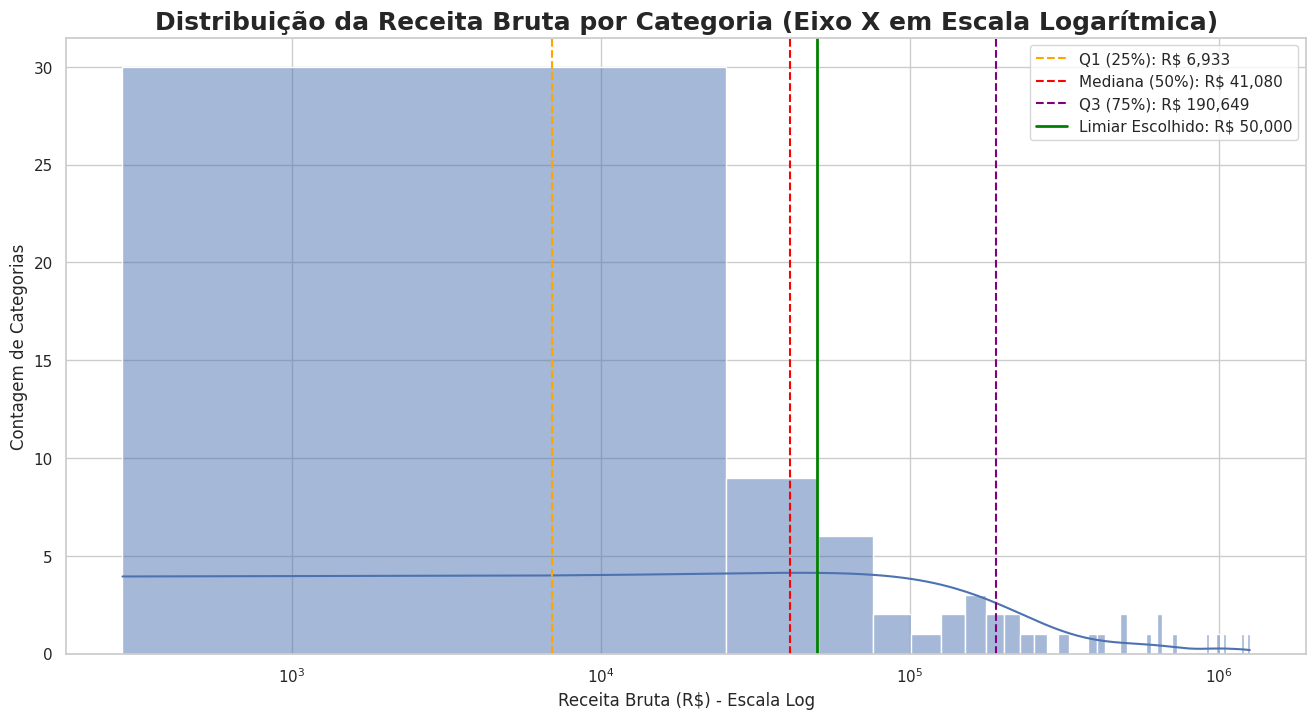

In [0]:
# Etapa 5: Análise da Distribuição da Receita por Categoria

# 1. Análise Quantitativa (describe) 
# Gera estatísticas descritivas da receita bruta por categoria.
print("Estatísticas Descritivas da Receita Bruta por Categoria:")
receita_stats_df = lucratividade_categoria_df.select("receita_bruta").describe()
display(receita_stats_df)

# 2. Preparação para Visualização 
# Converte os dados para Pandas para a plotagem.
receita_pd = lucratividade_categoria_df.select("receita_bruta").toPandas()

# CORREÇÃO: Calcular quartis usando approxQuantile do PySpark
# Os quartis são 0.25 (Q1), 0.50 (Mediana), 0.75 (Q3)
quantiles = lucratividade_categoria_df.approxQuantile(
    "receita_bruta", [0.25, 0.5, 0.75], 0.01
)

q1 = quantiles[0]
median = quantiles[1]
q3 = quantiles[2]

RECEITA_MINIMA = 50000 # O valor que estamos testando

#  3. Análise Visual (Histograma) 
# Cria um histograma para visualizar a distribuição da receita.
plt.figure(figsize=(16, 8))
sns.set_theme(style="whitegrid")
ax = sns.histplot(data=receita_pd, x='receita_bruta', bins=50, kde=True)

# Usa escala logarítmica no eixo X para melhor visualização de dados com grande variação.
ax.set_xscale('log')
plt.title('Distribuição da Receita Bruta por Categoria (Eixo X em Escala Logarítmica)', fontsize=18, weight='bold')
plt.xlabel('Receita Bruta (R$) - Escala Log', fontsize=12)
plt.ylabel('Contagem de Categorias', fontsize=12)

# Adiciona linhas verticais para marcar os quartis e nosso limiar escolhido.
plt.axvline(q1, color='orange', linestyle='--', label=f'Q1 (25%): R$ {q1:,.0f}')
plt.axvline(median, color='red', linestyle='--', label=f'Mediana (50%): R$ {median:,.0f}')
plt.axvline(q3, color='purple', linestyle='--', label=f'Q3 (75%): R$ {q3:,.0f}')
plt.axvline(RECEITA_MINIMA, color='green', linestyle='-', linewidth=2, label=f'Limiar Escolhido: R$ {RECEITA_MINIMA:,.0f}')

plt.legend()
plt.show()

### Etapa 6: Visualização da Composição da Receita Pós-Frete

Esta etapa aprofunda a compreensão da contribuição das categorias de produtos para a receita total, com um foco particular nas categorias identificadas pela Análise de Pareto (Etapa 4) como as de maior impacto financeiro. O objetivo é visualizar como a receita bruta dessas categorias se decompõe em "Receita Líquida Pós-Frete" e "Custo do Frete", fornecendo uma visão granular da estrutura de custos e lucratividade por categoria.

Será gerado um **gráfico de barras horizontais empilhadas** para as 10 categorias de maior impacto em receita. Cada barra representará uma categoria, e será segmentada para mostrar visualmente a proporção da receita que corresponde ao valor pós-frete e a parcela que é absorvida pelo custo do frete. Rótulos de dados serão adicionados dentro e no final das barras para fornecer os valores exatos e a receita bruta total por categoria, facilitando a interpretação imediata da composição financeira.

Esta visualização é fundamental para:

* **Identificar as principais fontes de receita:** Confirmar visualmente quais categorias são os pilares financeiros.
* **Compreender a estrutura de custos de frete:** Observar o impacto do frete na receita bruta de cada categoria de alto desempenho.
* **Suportar decisões estratégicas:** Fornecer insights para otimização de custos de frete, estratégias de precificação ou alocação de recursos para as categorias mais relevantes.

/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


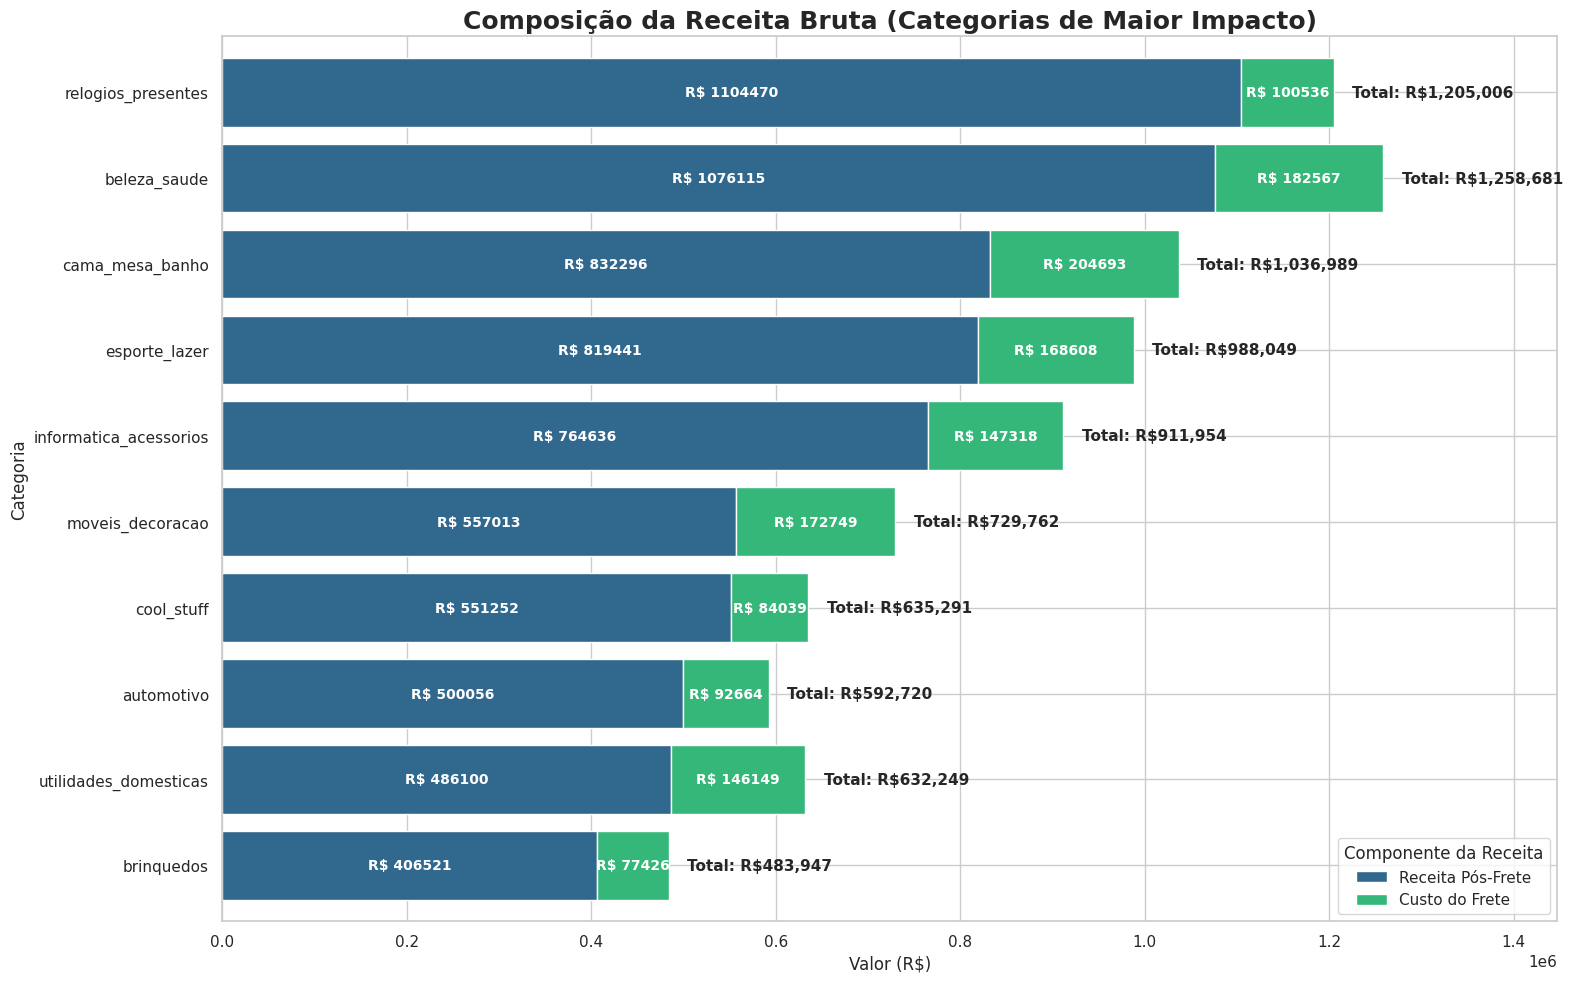

In [0]:
# Etapa 6: Visualização da Composição da Receita Pós-Frete

# 1. Preparação dos Dados 
# Usa o resultado da Análise de Pareto da Célula 4 ('categorias_pareto_receita').
# Adicionamos a ordenação aqui para garantir que o DataFrame esteja na ordem correta.
plot_pd = categorias_pareto_receita.limit(10).orderBy(F.col("receita_liquida_pos_frete").desc()).toPandas()

# Prepara os dados para o gráfico empilhado, definindo a categoria como índice.
plot_data = plot_pd.set_index('categoria')[['receita_liquida_pos_frete', 'custo_frete_total']]

# 2. Criação do Gráfico de Barras Empilhadas 
# Captura o eixo (ax) retornado pela função de plotagem para poder manipulá-lo.
ax = plot_data.plot(kind='barh', stacked=True, figsize=(16, 10), color=sns.color_palette("viridis", 2), width=0.8)

# 3. Adição de Rótulos de Dados
# Adiciona rótulos para cada segmento individualmente (dentro das barras).
# Estes valores mostram a composição da receita.
for container in ax.containers:
    ax.bar_label(
        container, 
        label_type='center', 
        fmt='R$ %.0f', 
        color='white', 
        weight='bold',
        fontsize=10
    )

# Adiciona o rótulo com o valor TOTAL no final de cada barra.
# Itera sobre as linhas do DataFrame para obter o valor total da receita bruta.
for i, total in enumerate(plot_pd['receita_bruta']):
    ax.text(
        total + 20000, # Posição x (depois da barra)
        i, # Posição y (o índice da barra)
        f'Total: R${total:,.0f}', # Texto formatado com separador de milhar
        va='center', # Alinhamento vertical
        ha='left', # Alinhamento horizontal
        weight='bold',
        fontsize=11
    )

# 4. Adição de Contexto e Títulos 
# Ajusta o título para refletir a análise de Pareto.
plt.title('Composição da Receita Bruta (Categorias de Maior Impacto)', fontsize=18, weight='bold')
plt.xlabel('Valor (R$)', fontsize=12)
plt.ylabel('Categoria', fontsize=12)
plt.gca().invert_yaxis() # Coloca a categoria de maior receita no topo
plt.legend(['Receita Pós-Frete', 'Custo do Frete'], title='Componente da Receita', loc='lower right')
# Ajusta o limite do eixo X para dar espaço aos rótulos de total
ax.set_xlim(right=plot_pd['receita_bruta'].max() * 1.15)


plt.tight_layout()
plt.show()

### Etapa 7: Análise e Visualização das Categorias de Maior Margem Percentual

Esta etapa finaliza a análise financeira com um foco nas categorias de produtos que demonstram a maior eficiência em termos de lucratividade, mensurada pela **margem percentual pós-frete**. Enquanto a Etapa 6 focou na receita total e sua composição, esta etapa direciona a atenção para a capacidade de cada categoria gerar lucro após a dedução dos custos de envio.

O processo envolve:

1.  **Identificação e Seleção:** O DataFrame de lucratividade por categoria será ordenado pela margem percentual em ordem decrescente, e as 10 categorias com as maiores margens serão selecionadas para análise detalhada. Esta seleção permite focar nas categorias mais eficientes financeiramente.

2.  **Visualização Gráfica:** Será criado um **gráfico de barras horizontais** para apresentar visualmente as 10 categorias selecionadas e seus respectivos valores de margem percentual pós-frete. Rótulos de valor serão adicionados diretamente nas barras para facilitar a leitura precisa das margens.

Esta visualização é crucial para:

* **Destacar a eficiência operacional:** Identificar as categorias que convertem a maior parte de sua receita bruta em lucro, indicando possivelmente melhor gestão de custos de produtos ou estratégias de precificação superiores.
* **Informar estratégias de portfólio:** Ajudar na decisão de quais categorias focar para otimização de rentabilidade ou para replicar modelos de sucesso.
* **Monitorar a saúde financeira:** Servir como um indicador-chave de desempenho para a lucratividade do portfólio de produtos.

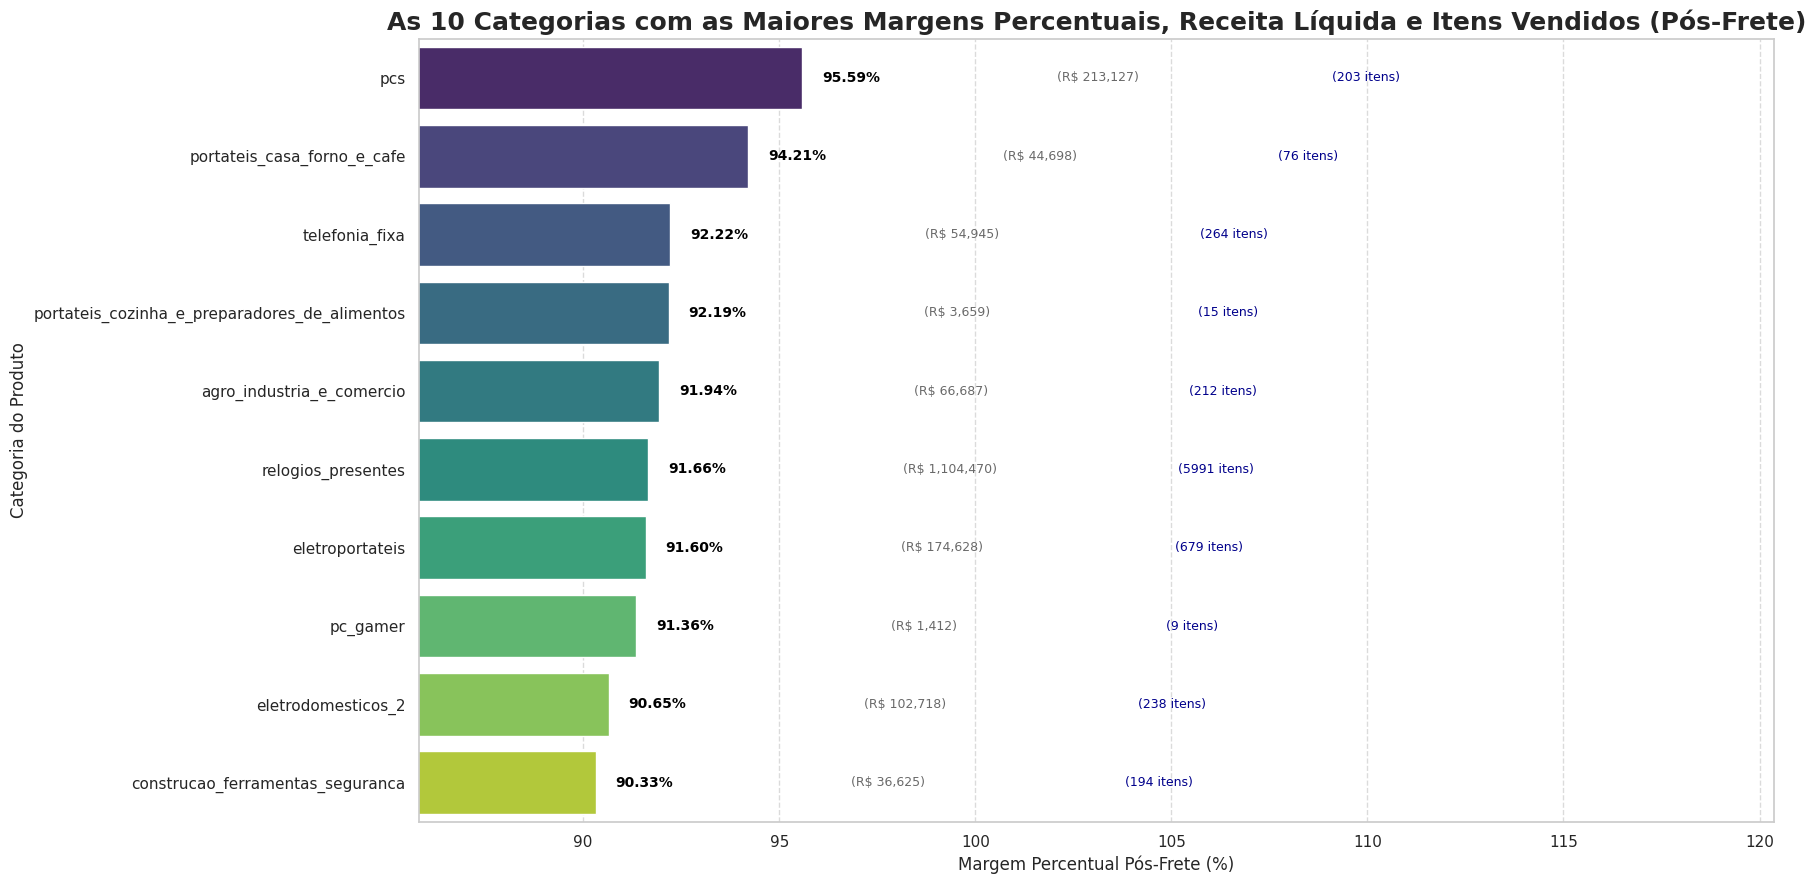

In [0]:
# Etapa 7: Análise e Visualização das Categorias de Maior Margem Percentual

# 1. Ordenação e Seleção das 10 Categorias com as Maiores Margens 
# Ordena o DataFrame 'lucratividade_categoria_df' pela margem percentual de forma descendente
# e seleciona as 10 primeiras.


categorias_maior_margem_df = lucratividade_categoria_df.orderBy(
    F.col("margem_percentual_pos_frete").desc()
).limit(10)

# Converte o DataFrame do PySpark para Pandas para visualização
# Certifique-se de que 'receita_liquida_pos_frete' e 'total_itens_vendidos'
# também estão presentes no Pandas DataFrame.
categorias_maior_margem_pd = categorias_maior_margem_df.toPandas()

# 2. Criação do Gráfico de Barras 
plt.figure(figsize=(18, 9)) # Aumentei um pouco mais a largura para os três rótulos
sns.barplot(
    data=categorias_maior_margem_pd,
    y='categoria',
    x='margem_percentual_pos_frete',
    palette='viridis' # 'viridis' é uma boa opção de paleta para dados quantitativos
)

# Adicionando rótulos de valor para Margem Percentual, Receita Líquida Pós-Frete e Quantidade Vendida
for index, row in categorias_maior_margem_pd.iterrows():
    # Rótulo da Margem Percentual (dentro ou perto da barra)
    plt.text(
        row['margem_percentual_pos_frete'] + 0.5, # Posição X ajustada
        index,                                    # Posição Y (índice da barra)
        f'{row["margem_percentual_pos_frete"]:.2f}%', # Formata com 2 casas decimais e '%'
        color='black',
        ha="left",                                # Alinhamento horizontal à esquerda
        va='center',                              # Alinhamento vertical centralizado
        fontsize=10,
        weight='bold' # Para destacar
    )
    
    # Rótulo do Valor Bruto da Receita Líquida Pós-Frete
    # Posicionaremos ele um pouco mais à direita
    plt.text(
        row['margem_percentual_pos_frete'] + 6.5, # Ajuste de espaçamento
        index,                                 # Posição Y (índice da barra)
        f'(R$ {row["receita_liquida_pos_frete"]:,.0f})', # Formata como "R$ 123.456" com separador de milhar
        color='dimgray',                       # Cor diferente para distinguir
        ha="left",
        va='center',
        fontsize=9
    )

    # Rótulo da Quantidade Vendida
    # Posicionaremos ele ainda mais à direita
    plt.text(
        row['margem_percentual_pos_frete'] + 13.5, # Ajuste de espaçamento
        index,                                  # Posição Y (índice da barra)
        f'({row["total_itens_vendidos"]:.0f} itens)', # Formata como "123 itens"
        color='darkblue',                       # Outra cor para distinguir
        ha="left",
        va='center',
        fontsize=9
    )


plt.title('As 10 Categorias com as Maiores Margens Percentuais, Receita Líquida e Itens Vendidos (Pós-Frete)', fontsize=18, weight='bold')
plt.xlabel('Margem Percentual Pós-Frete (%)', fontsize=12)
plt.ylabel('Categoria do Produto', fontsize=12)

# Ajusta o limite do eixo X para dar mais destaque à variação nas margens elevadas,
# e também para dar espaço a TODOS os novos rótulos.
plt.xlim(categorias_maior_margem_pd['margem_percentual_pos_frete'].min() * 0.95, 
         categorias_maior_margem_pd['margem_percentual_pos_frete'].max() * 1.05 + 20) # Valor final ajustado para espaçamento

plt.grid(axis='x', linestyle='--', alpha=0.7) # Adiciona grid no eixo X
plt.tight_layout() # Ajusta o layout para evitar sobreposição de elementos
display(plt.gcf())

# Adiciona esta linha para fechar a figura após exibi-la
plt.close()

## Conclusão da Análise Financeira por Categoria

Esta análise detalhada das categorias de produtos forneceu insights cruciais sobre a performance financeira do negócio, focando na receita bruta, receita líquida pós-frete, margens de lucro e volume de vendas.

### 1. Visão Geral da Distribuição da Receita (Etapa 5)

A distribuição da Receita Bruta por Categoria, visualizada em escala logarítmica, revela uma característica comum em muitos negócios: a receita é altamente concentrada em um pequeno número de categorias.

- A **mediana da receita bruta por categoria** é de **R$ 41.080**.
- O **3º quartil (Q3)** atinge **R$ 190.649**.
- O **valor máximo** supera **R$ 1,2 milhão**.

Isso indica que a maioria das categorias opera com volumes de receita menores, enquanto poucas categorias concentram a maior parte da receita. A definição de um limiar de **R$ 50.000** como "receita mínima" estabelece um ponto de corte para identificar as categorias de maior relevância financeira.

### 2. Análise de Pareto da Receita Pós-Frete (Etapas 4 e 6)

A aplicação do **Princípio de Pareto** confirmou a concentração da receita:

- Cerca de **15 categorias** são responsáveis por **80% da receita líquida pós-frete**.
- O **gráfico de barras empilhadas** da **Composição da Receita Bruta** ilustra claramente essa concentração.

Categorias como:

- `relogios_presentes`
- `beleza_saude`
- `cama_mesa_banho`
- `esporte_lazer`
- `informatica_acessorios`

são os **principais motores de receita**. A visualização detalha a **Receita Pós-Frete** versus **Custo do Frete**, demonstrando que, nas categorias de maior impacto, o custo de envio é relativamente pequeno em relação ao total arrecadado.

### 3. Categorias de Maior Margem Percentual, Receita Líquida e Itens Vendidos (Etapa 7)

A análise das **10 categorias com maiores margens percentuais pós-frete** trouxe insights importantes ao combinar **eficiência e volume**:

#### Altíssima Eficiência de Margem

Algumas categorias apresentam **margens percentuais superiores a 90%**, como:

- `pcs`: 95.59%
- `portaateis_casa_forno_e_cafe`: 94.21%
- `telefonia_fixa`: 92.22%

Isso indica **baixíssimo impacto do frete** no resultado financeiro dessas categorias.

#### Diferenciação por Volume e Receita Absoluta

- **Categorias de Alto Impacto e Alta Eficiência**:
  - `relogios_presentes`: 91.66% de margem, R$ 1.104.470 de receita líquida, 5.991 itens vendidos.
  - `eletroportateis`: 91.60%, R$ 174.628, 679 itens.
  - `eletrodomesticos_2`: 90.65%, R$ 102.718, 238 itens.

- **Categorias com Alta Eficiência, mas Baixo Volume/Impacto**:
  - `pc_gamer`: 91.36% de margem, apenas R$ 1.412 de receita líquida e 9 itens vendidos.
  - `portaateis_cozinha_e_preparadores_de_alimentos`: R$ 3.659, 15 itens.
  - `construcao_ferramentas_seguranca`: R$ 36.625, 194 itens.

Esses casos demonstram que **altas margens percentuais não garantem impacto financeiro significativo**, se não vierem acompanhadas de volume e ticket médio relevantes.
